In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                     | 0/60000 [00:00<?, ?it/s]

 11%|███████████▌                                                                                           | 6740/60000 [00:00<00:00, 67391.23it/s]

 22%|██████████████████████▉                                                                               | 13480/60000 [00:00<00:00, 64895.33it/s]

 33%|█████████████████████████████████▉                                                                    | 19976/60000 [00:00<00:00, 63342.44it/s]

 44%|████████████████████████████████████████████▋                                                         | 26316/60000 [00:00<00:00, 59401.36it/s]

 55%|████████████████████████████████████████████████████████                                              | 32947/60000 [00:00<00:00, 61744.99it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 39498/60000 [00:00<00:00, 62973.51it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 46124/60000 [00:00<00:00, 64017.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 52664/60000 [00:00<00:00, 64448.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 59435/60000 [00:00<00:00, 65451.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 63712.83it/s]

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 6631/10000 [00:00<00:00, 66300.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 63967.11it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 ho6dji6w


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ho6dji6w:best, 409.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                       | 0/383 [00:00<?, ?it/s]

  0%|▎                                                                                                              | 1/383 [00:00<05:03,  1.26it/s]

  3%|███▋                                                                                                          | 13/383 [00:00<00:19, 19.30it/s]

  7%|███████▊                                                                                                      | 27/383 [00:01<00:08, 40.50it/s]

 10%|███████████▍                                                                                                  | 40/383 [00:01<00:05, 58.12it/s]

 14%|███████████████▌                                                                                              | 54/383 [00:01<00:04, 75.19it/s]

 18%|███████████████████▌                                                                                          | 68/383 [00:01<00:03, 89.70it/s]

 21%|███████████████████████▎                                                                                      | 81/383 [00:01<00:03, 99.75it/s]

 25%|██████████████████████████▊                                                                                  | 94/383 [00:01<00:02, 107.19it/s]

 28%|██████████████████████████████▏                                                                             | 107/383 [00:01<00:02, 112.97it/s]

 32%|██████████████████████████████████                                                                          | 121/383 [00:01<00:02, 118.17it/s]

 35%|██████████████████████████████████████                                                                      | 135/383 [00:01<00:02, 121.71it/s]

 39%|██████████████████████████████████████████                                                                  | 149/383 [00:01<00:01, 124.42it/s]

 43%|█████████████████████████████████████████████▉                                                              | 163/383 [00:02<00:01, 126.38it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 177/383 [00:02<00:01, 127.68it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 191/383 [00:02<00:01, 127.89it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 204/383 [00:02<00:01, 128.36it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 218/383 [00:02<00:01, 129.48it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 232/383 [00:02<00:01, 129.81it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 246/383 [00:02<00:01, 127.03it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 259/383 [00:02<00:00, 126.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 272/383 [00:02<00:00, 125.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 285/383 [00:03<00:00, 124.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 298/383 [00:03<00:00, 124.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 311/383 [00:03<00:00, 123.62it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 324/383 [00:03<00:00, 122.30it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 337/383 [00:03<00:00, 123.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 350/383 [00:03<00:00, 123.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 363/383 [00:03<00:00, 122.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 376/383 [00:03<00:00, 122.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:03<00:00, 98.14it/s]

train - OK


  0%|                                                                                                                        | 0/96 [00:00<?, ?it/s]

  1%|█▏                                                                                                              | 1/96 [00:00<00:13,  6.98it/s]

 14%|███████████████                                                                                                | 13/96 [00:00<00:01, 63.16it/s]

 27%|██████████████████████████████                                                                                 | 26/96 [00:00<00:00, 89.15it/s]

 41%|████████████████████████████████████████████▋                                                                 | 39/96 [00:00<00:00, 102.63it/s]

 54%|███████████████████████████████████████████████████████████▌                                                  | 52/96 [00:00<00:00, 110.05it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                   | 65/96 [00:00<00:00, 113.95it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                    | 78/96 [00:00<00:00, 116.25it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 91/96 [00:00<00:00, 119.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 94.81it/s]

val - OK


  0%|                                                                                                                        | 0/81 [00:00<?, ?it/s]

  1%|█▍                                                                                                              | 1/81 [00:00<00:12,  6.53it/s]

 16%|█████████████████▊                                                                                             | 13/81 [00:00<00:01, 60.34it/s]

 32%|███████████████████████████████████▋                                                                           | 26/81 [00:00<00:00, 86.08it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 39/81 [00:00<00:00, 99.03it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                       | 52/81 [00:00<00:00, 108.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                     | 65/81 [00:00<00:00, 114.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 78/81 [00:00<00:00, 118.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 89.18it/s]

test InD - OK


  0%|                                                                                                                       | 0/536 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/536 [00:00<01:24,  6.35it/s]

  2%|██▋                                                                                                           | 13/536 [00:00<00:08, 59.15it/s]

  5%|█████▎                                                                                                        | 26/536 [00:00<00:05, 85.53it/s]

  7%|████████                                                                                                      | 39/536 [00:00<00:04, 99.75it/s]

 10%|██████████▌                                                                                                  | 52/536 [00:00<00:04, 107.37it/s]

 12%|█████████████▏                                                                                               | 65/536 [00:00<00:04, 113.11it/s]

 14%|███████████████▋                                                                                             | 77/536 [00:00<00:03, 115.11it/s]

 17%|██████████████████▎                                                                                          | 90/536 [00:00<00:03, 116.91it/s]

 19%|████████████████████▊                                                                                       | 103/536 [00:00<00:03, 118.09it/s]

 22%|███████████████████████▎                                                                                    | 116/536 [00:01<00:03, 118.89it/s]

 24%|█████████████████████████▊                                                                                  | 128/536 [00:01<00:03, 118.89it/s]

 26%|████████████████████████████▍                                                                               | 141/536 [00:01<00:03, 119.61it/s]

 29%|███████████████████████████████                                                                             | 154/536 [00:01<00:03, 121.40it/s]

 31%|█████████████████████████████████▋                                                                          | 167/536 [00:01<00:02, 123.50it/s]

 34%|████████████████████████████████████▎                                                                       | 180/536 [00:01<00:02, 125.31it/s]

 36%|██████████████████████████████████████▉                                                                     | 193/536 [00:01<00:02, 126.42it/s]

 38%|█████████████████████████████████████████▌                                                                  | 206/536 [00:01<00:02, 127.12it/s]

 41%|████████████████████████████████████████████▎                                                               | 220/536 [00:01<00:02, 128.08it/s]

 43%|██████████████████████████████████████████████▉                                                             | 233/536 [00:02<00:02, 127.64it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 246/536 [00:02<00:02, 127.75it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 259/536 [00:02<00:02, 127.90it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 272/536 [00:02<00:02, 127.83it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 285/536 [00:02<00:01, 128.45it/s]

 56%|████████████████████████████████████████████████████████████                                                | 298/536 [00:02<00:01, 128.85it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 311/536 [00:02<00:01, 128.64it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 324/536 [00:02<00:01, 127.86it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 337/536 [00:02<00:01, 125.89it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 350/536 [00:02<00:01, 125.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 363/536 [00:03<00:01, 124.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 376/536 [00:03<00:01, 124.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 389/536 [00:03<00:01, 124.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 402/536 [00:03<00:01, 124.20it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 415/536 [00:03<00:00, 124.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 428/536 [00:03<00:00, 124.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 441/536 [00:03<00:00, 123.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 454/536 [00:03<00:00, 124.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 467/536 [00:03<00:00, 124.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 480/536 [00:04<00:00, 123.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 493/536 [00:04<00:00, 123.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 506/536 [00:04<00:00, 124.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 519/536 [00:04<00:00, 125.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 532/536 [00:04<00:00, 126.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:04<00:00, 117.76it/s]

test OoD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

 14%|███████████████▎                                                                                             | 14/100 [00:00<00:00, 132.01it/s]

 28%|██████████████████████████████▌                                                                              | 28/100 [00:00<00:00, 133.68it/s]

 42%|█████████████████████████████████████████████▊                                                               | 42/100 [00:00<00:00, 133.70it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 56/100 [00:00<00:00, 133.02it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 70/100 [00:00<00:00, 132.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 84/100 [00:00<00:00, 133.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 98/100 [00:00<00:00, 132.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 132.58it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 3, 32, 32) (24476, 2048) (24476, 256) (24476, 5) (24476,)
(6120, 3, 32, 32) (6120, 2048) (6120, 256) (6120, 5) (6120,)
(5139, 3, 32, 32) (5139, 2048) (5139, 256) (5139, 5) (5139,)
(34265, 3, 32, 32) (34265, 2048) (34265, 256) (34265, 5) (34265,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


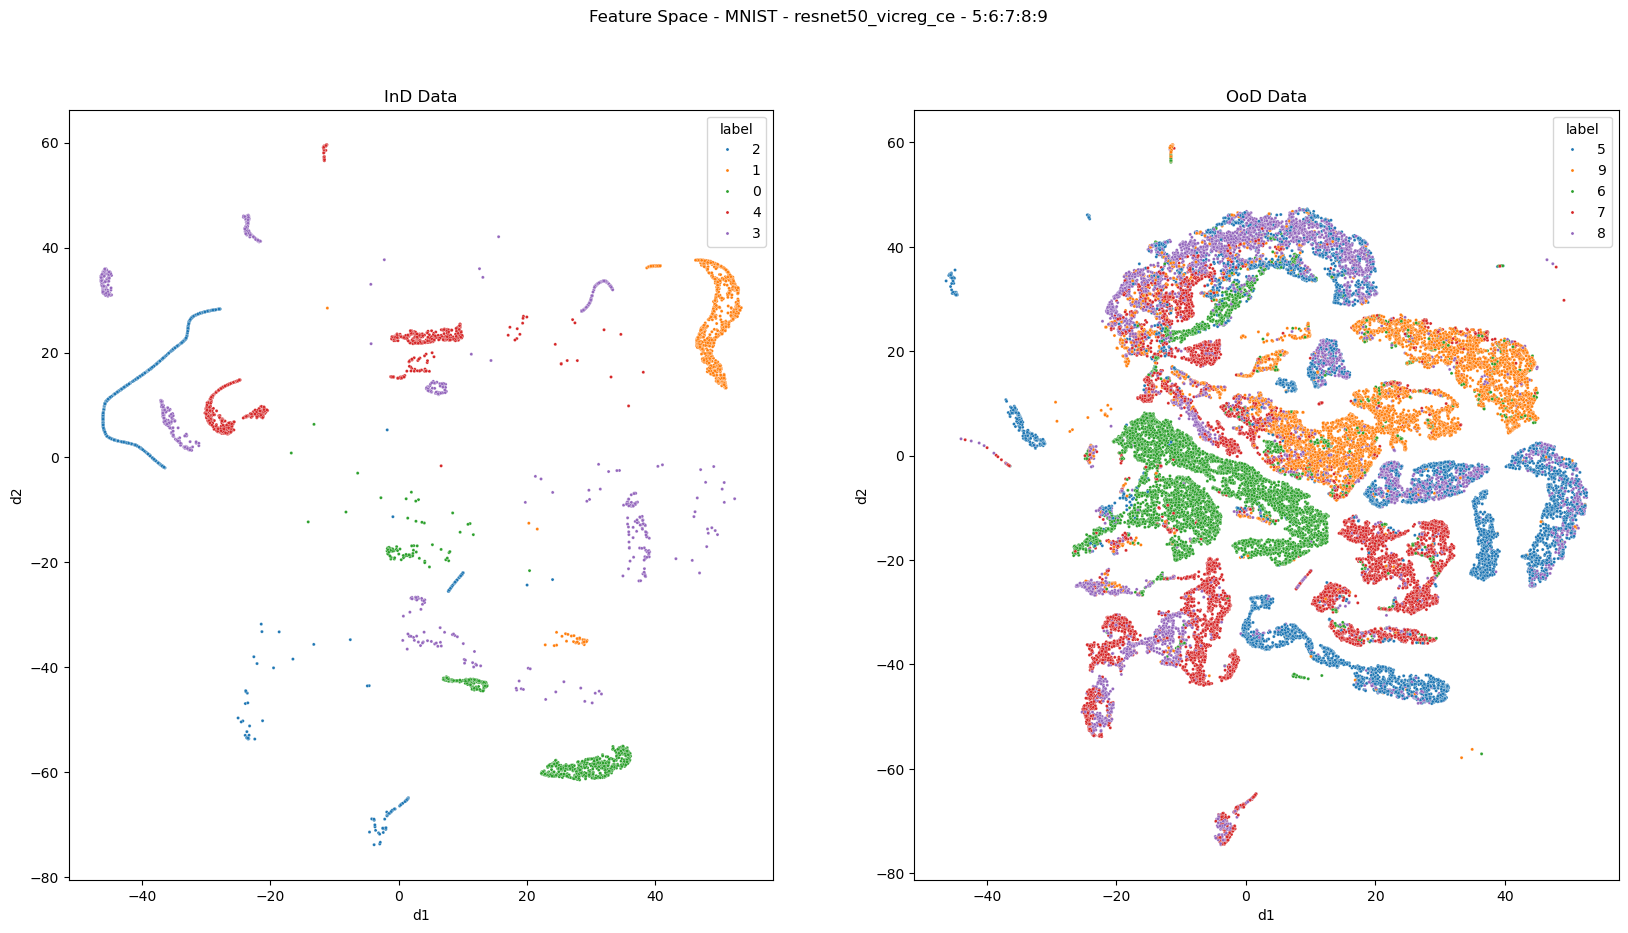

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

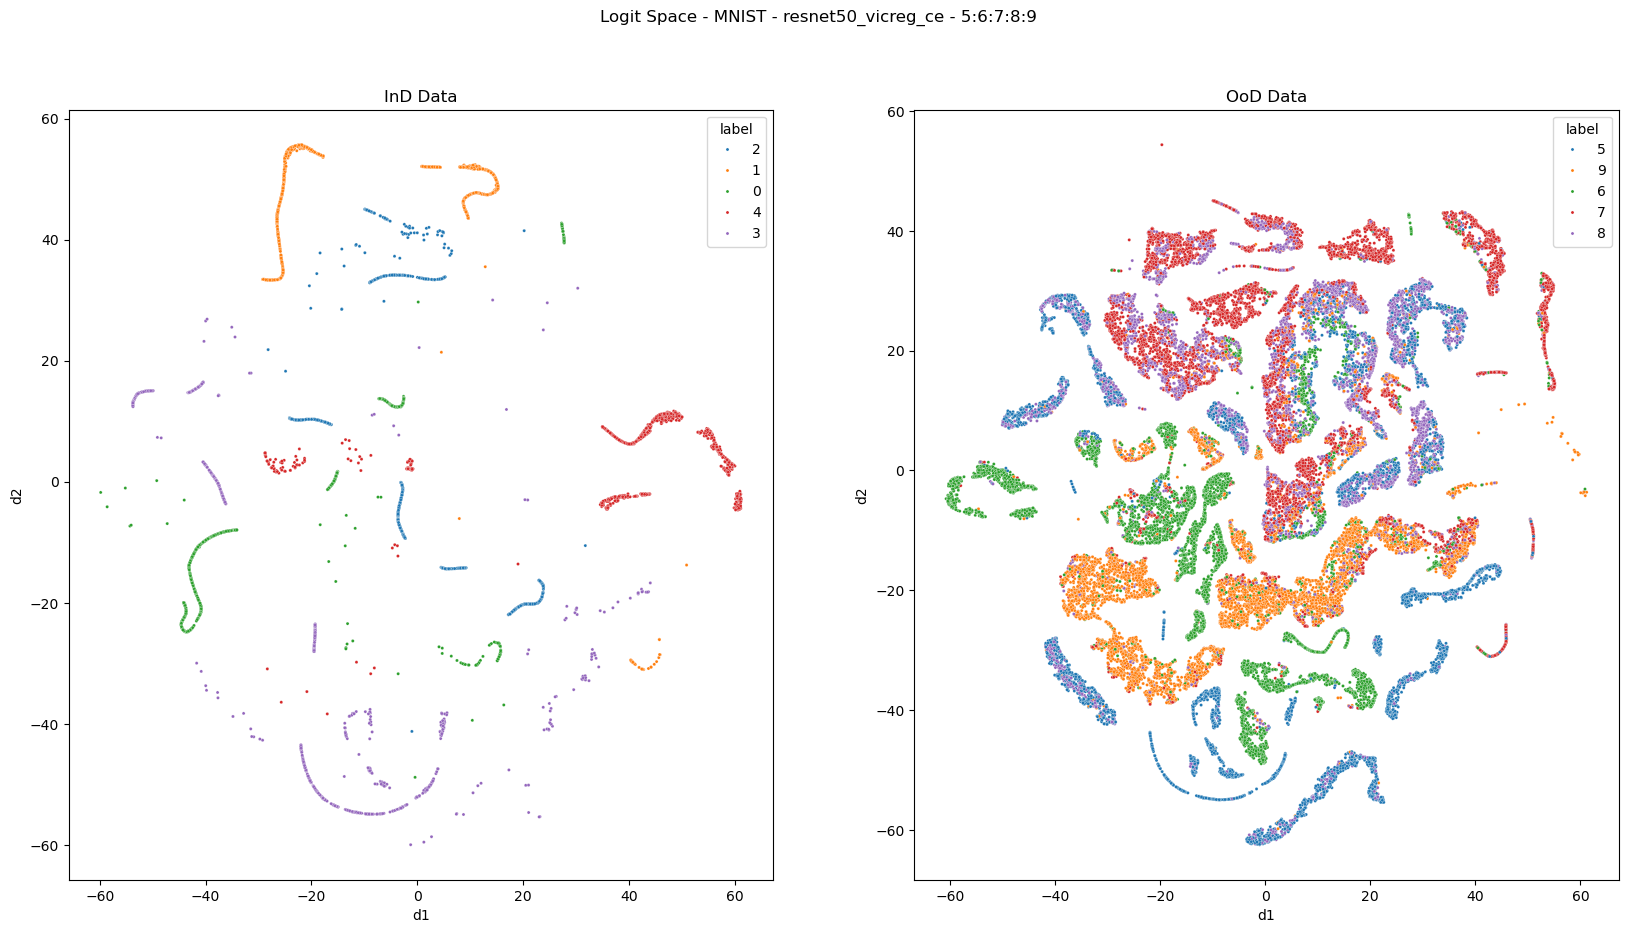

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:05<00:15,  5.01s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:10<00:10,  5.14s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:15<00:05,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.19s/it]

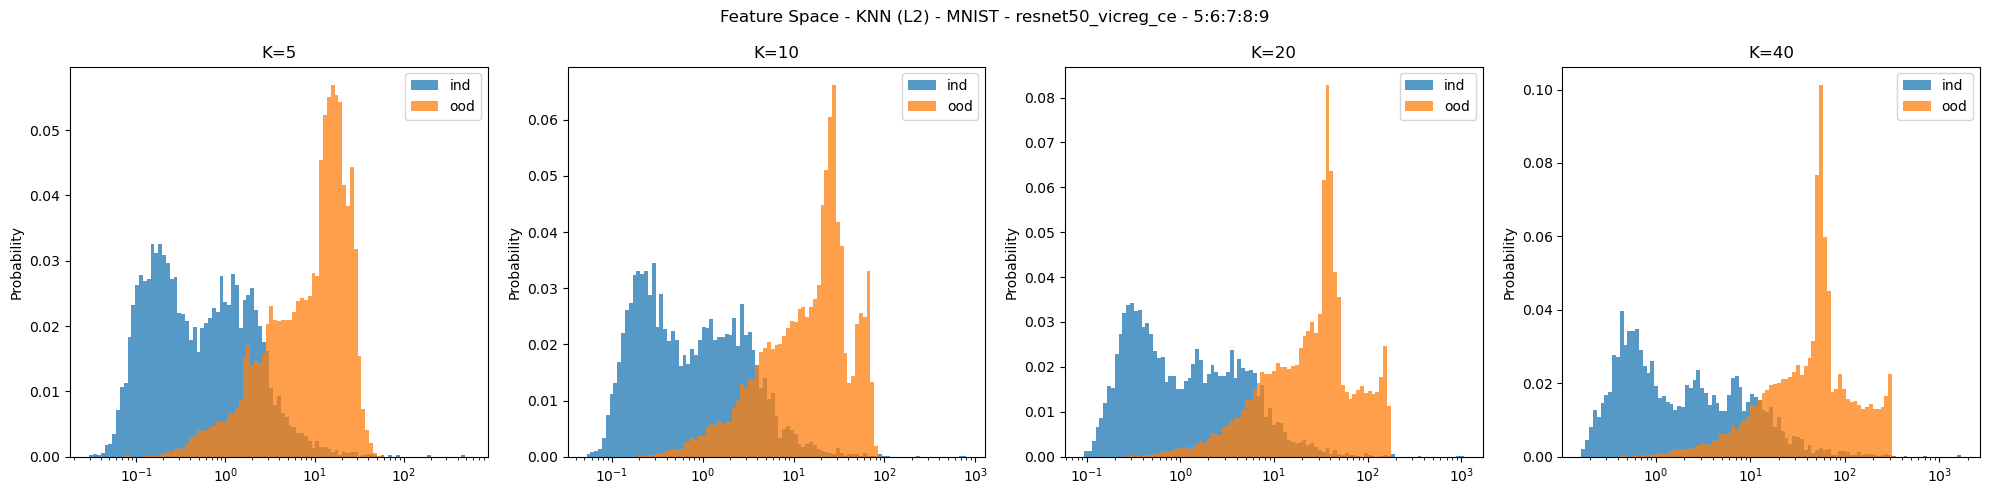

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:14,  4.82s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:09<00:09,  4.82s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:14<00:04,  4.92s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.96s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.93s/it]

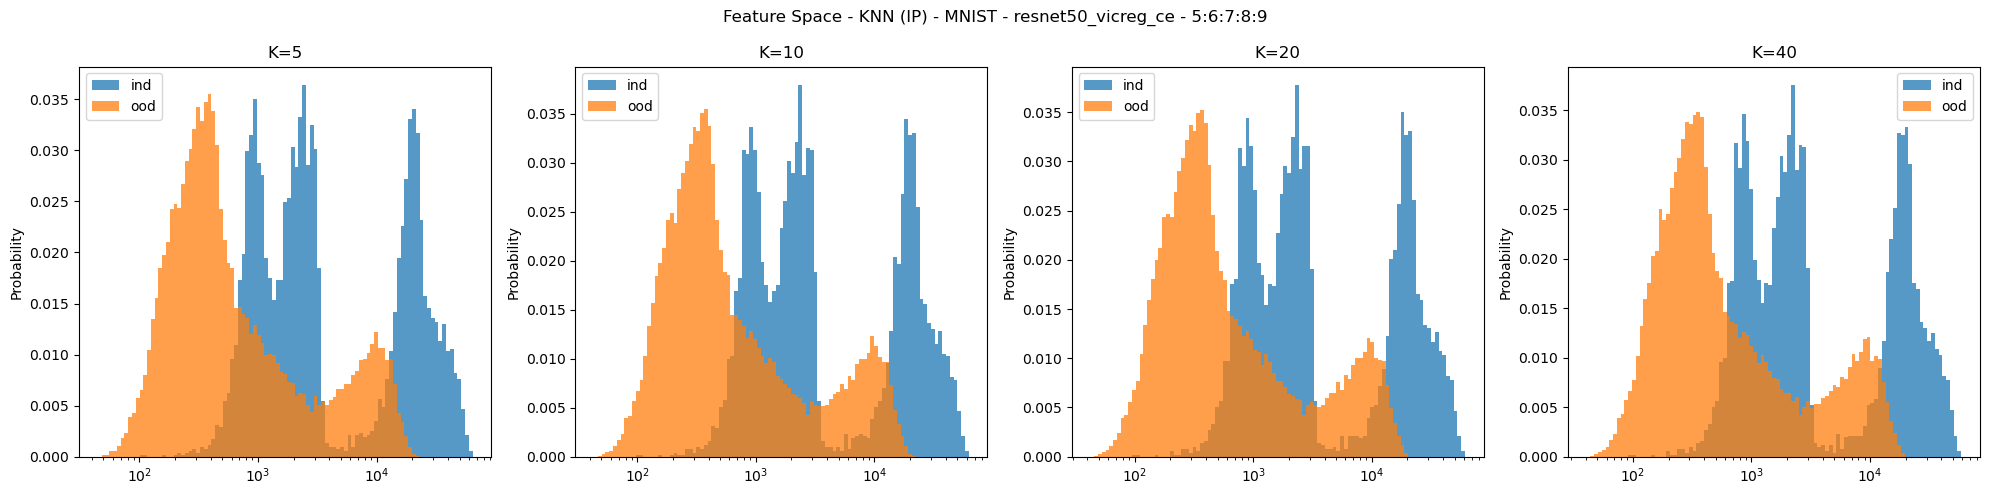

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:14,  4.76s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:09<00:09,  4.75s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:14<00:04,  4.78s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.87s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.83s/it]

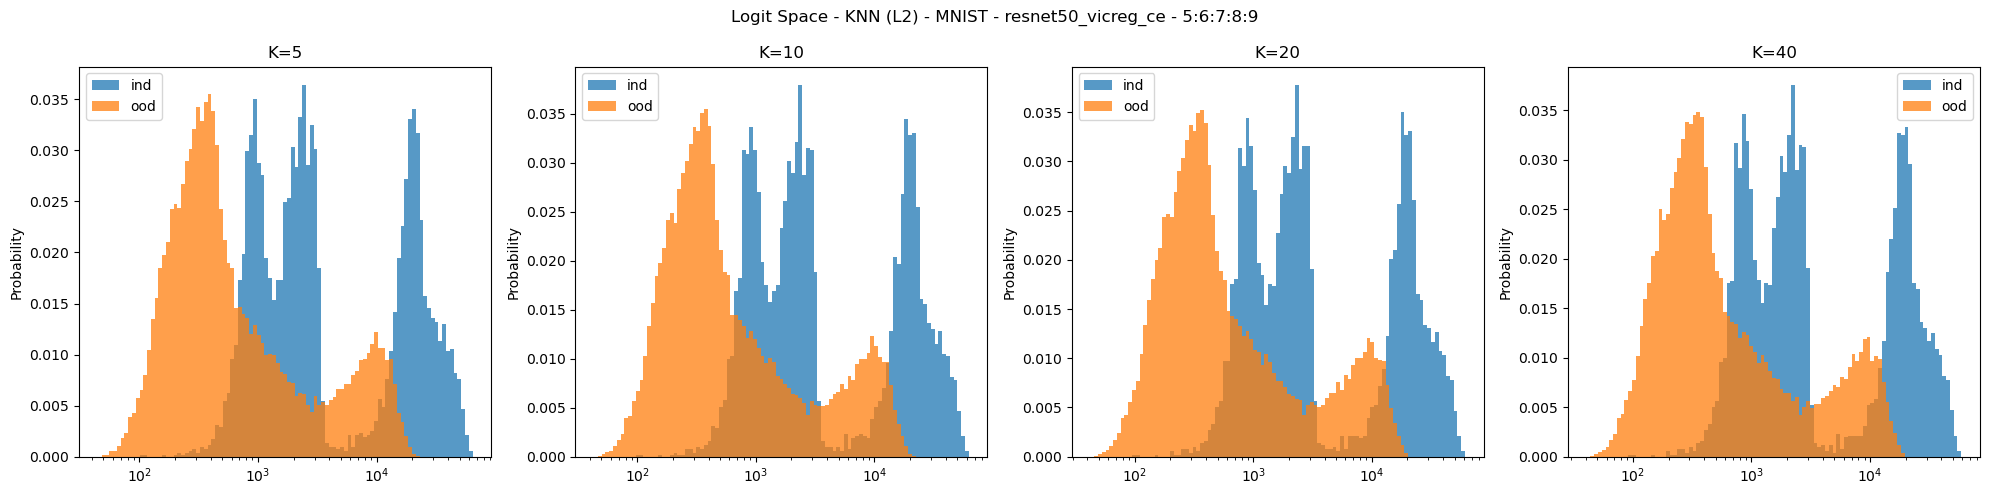

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:05<00:15,  5.00s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:09<00:09,  4.86s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:14<00:04,  4.86s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.91s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.90s/it]

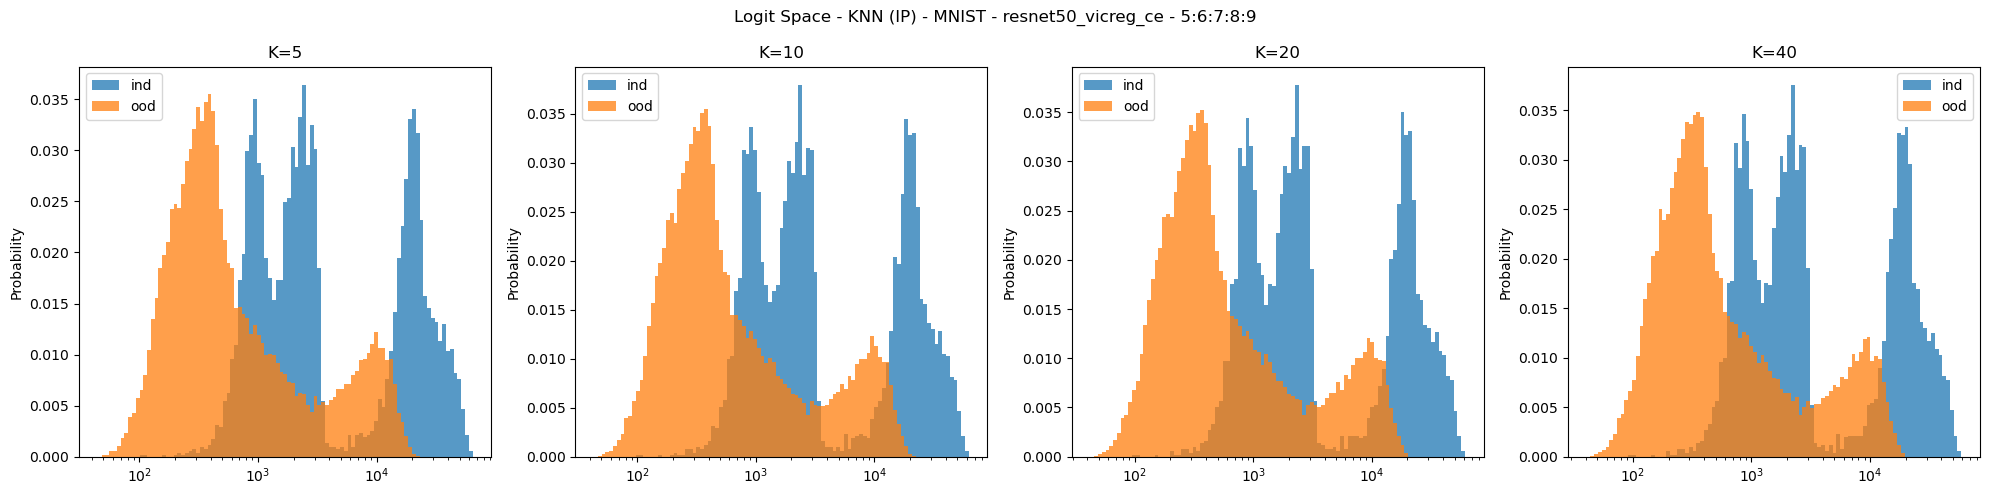

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

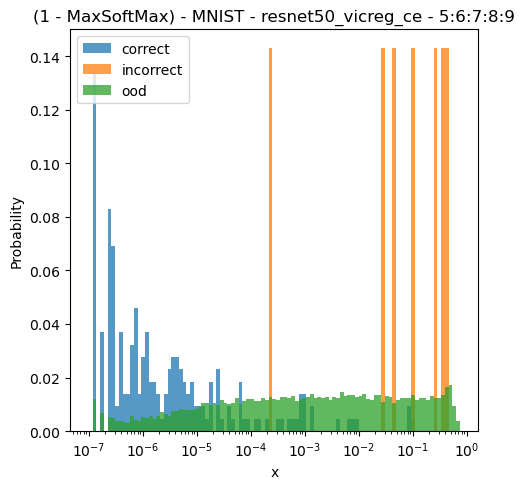

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()